In [1]:
# Allow access to google drive for working with images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import torch
from torch import nn

print("Torch Version: ", torch.__version__)

# Setup device-agnoistc code
device = "cuda" if torch.cuda.is_available else "cpu"
print("Available Device:", device)

# Setting Random Seed for Reproducibility
RANDOM_SEED = 0

# Set seed for torch
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

Torch Version:  2.1.0+cu118
Available Device: cuda


# Enter Path to Project Folder

In [3]:
PROJECT_DIR = "/content/drive/MyDrive/mole_project/"
sys.path.append(PROJECT_DIR)

# File Paths

In [4]:
from pathlib import Path

# Setup path to data folder
image_path = Path(os.path.join(PROJECT_DIR, "melanoma_cancer_dataset"))

# Setup Train and Testing Paths
train_dir = Path(os.path.join(image_path, "train"))
test_dir = Path(os.path.join(image_path, "test"))

# Visualize the train and test paths
train_dir, test_dir

(PosixPath('/content/drive/MyDrive/mole_project/melanoma_cancer_dataset/train'),
 PosixPath('/content/drive/MyDrive/mole_project/melanoma_cancer_dataset/test'))

# 2) Image Transformations

In [5]:
from src.transformations import train_transform_alexnet, test_transform_alexnet

# import the train and test transformations for the images
train_transform = train_transform_alexnet
test_transform = test_transform_alexnet

print("Train Transformation")
print(train_transform)
print()
print("Test Transformation")
print(test_transform)

Train Transformation
Compose(
    RandomHorizontalFlip(p=0.05)
    RandomApply(
    p=0.05
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
)
    RandomApply(
    p=0.05
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
)
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
)

Test Transformation
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
)


# 3) Defining Testing Data

In [6]:
from src.dataloader import load_train_val_test

# Load the train, validation and test datasets
train_data, val_data, test_data = load_train_val_test(train_dir, train_transform, test_dir, test_transform, val_perc=0.1)

# Check the length of the test dataset
print(f"Length of Test: {len(test_data)}")
print()
print(f"Dimensions of Image: {train_data[0][0].shape}")

Length of Test: 2000

Dimensions of Image: torch.Size([3, 224, 224])


# 4) Load data into data loader

In [7]:
from src.dataloader import load_data_into_dataloader

# Define Batch Size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Load each of the datasets into a data loader
test_dataloader = load_data_into_dataloader(test_data, BATCH_SIZE, NUM_WORKERS)

test_dataloader

# 6) Loading Trained Model Parameters

In [8]:
# Model Name
MODEL_NAME = f"AlexNet_10_epochs"

# The directory to store the model
models_dir = os.path.join(PROJECT_DIR, "models")
file_path = os.path.join(models_dir, MODEL_NAME + ".pth")

## Load the Model Parameters

In [9]:
import torchvision.models as models

# Create an instance of the model
model_0 = models.alexnet(pretrained=False).to(device)
model_0.classifier[6] = torch.nn.Linear(4096, 1).to(device)

# Load the saved model state
model_0.load_state_dict(torch.load(file_path))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [10]:
model_0

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# 8) Test Against Train Data

Model had a Loss of: 0.464364692568779
Model had an accuracy of: 0.764616935483871
True Positive (TP): 821
True Negative (TN): 696
False Negative (FN): 170
False Positive (FP): 297

Precision: 0.7343470483005367
Recall: 0.8284561049445005
F1 Score: 0.7785680417259364
Accuracy: 0.764616935483871
Specificity: 0.7009063444108762
AUC: 0.873723531928342


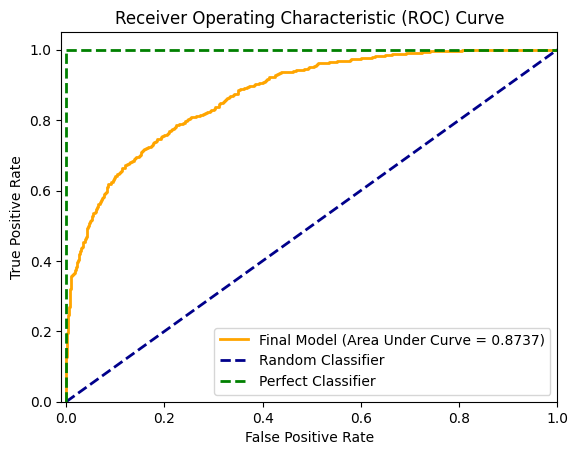

In [11]:
from src.visualizations import get_performance_metrics
from src.training_script import test as Test

get_performance_metrics(test_fn=Test,
                        model=model_0,
                        test_dataloader=test_dataloader,
                        loss_fn=nn.BCEWithLogitsLoss(),
                        device=device)

# 9) Grad-Cam Visualization

In [18]:
# Decide which image to look at using index
INDEX = 1071

Ouput logits: 
tensor([[3.7301]], device='cuda:0')

Output prediction probabilities: 
tensor([[0.9766]], device='cuda:0')

Ouput prediction label: 
tensor([[1.]], device='cuda:0')

Actual label: 
1


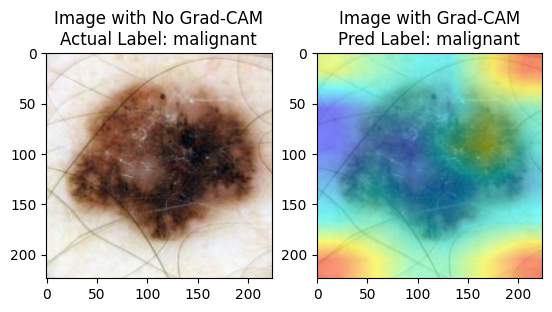

In [19]:
from src.visualizations import visualize_image_with_gradcam

visualize_image_with_gradcam(dataset=test_data,
                             index=INDEX,
                             model=model_0,
                             target_layer=model_0.features[-1],
                             device=device)